In [79]:
import scipy as scp
import numpy as np
import time
import datetime
#from datetime import timedelta
import matplotlib.pyplot as plt



print("hello world")


hello world


In [178]:
#class gb():
start_time0 = time.time()
start_time = datetime.datetime.fromtimestamp(start_time0)
end_time = 0
def printAlligned(message, variable, unit, spaces=20):
    output = print("{:{space}s}= {} {}".format(message, variable, unit, space=spaces))
    return output
def debug(level='partial'):
    match level:
        case 'partial':
            print('   DEBUG LEVEL PARTIAL')
            print("Iteration {} at current time = {} seconds".format(stepN, t))
            printAlligned('S position',Spos, 'm')
            printAlligned('S velocity', Svel, 'm s^-1')
            printAlligned('S acceleration', Sacc, 'm s^-2')
        case 'full':
            print('   DEBUG LEVEL FULL')
            print("List of globals:")
            print("Iteration {} at current time = {} seconds".format(stepN, t))
            printAlligned('S position',Spos, 'm')
            printAlligned('S velocity', Svel, 'm s^-1')
            printAlligned('S acceleration', Sacc, 'm s^-2')
        case 'start':
            print('   DEBUG LEVEL START')
            printAlligned('Start time', start_time, 'seconds', spaces=15)
            printAlligned('S position',Spos, 'm')
            printAlligned('S velocity', Svel, 'm s^-1')
            printAlligned('S acceleration', Sacc, 'm s^-2')
        case 'end':
            print('   DEBUG LEVEL END')
            end_time = time.time()
            printAlligned('end_time',end_time, 'seconds', spaces=15)
            printAlligned('Wall runtime',end_time-start_time,spaces=15)

def initialize(mode,inSpos=[0,0],inSvel=[0,0],inSacc=[0,0],stepsize=[1,1],startdebuglevel='start'):
    # Constants
    match mode:
        case 'zeros':
            global G0, d, mE, mM, mT, rE, rM, P, l2, l2vel, aSt, aDy, stepN, t
            G0 = 6.6726e-11
            d = 3.844e8                                     #Earth-Moon separation
            mE = 5.9742e24                                  #Earth Mass
            mM = 7.35e22                                    #Moon mass
            mT = mE + mM                                    #Barycentre mass
            rE = d*mM/mT                                    #Barycentre-Earth separation
            rM = d*mE/mT                                    #Barycentre-Moon separation
            P = np.sqrt(4 * np.pi**2 * (d)**3 / G0 / mT)    #Orbital period
            aSt = stepsize[0]
            l2 = rM + d*(mM/3/mE)**(1/3)
            l2vel = 2*np.pi * l2 / P
    

            # Variables
            aDy = stepsize[1]
            stepN = 0
            t = 0

            # Vectors
            global Epos, Mpos, Spos, Svel, Sacc

            Epos = np.zeros(2)
            Mpos = np.zeros(2)

            Spos = np.zeros(2)
            Svel = np.zeros(2)
            Sacc = np.zeros(2)
            debug(startdebuglevel)
            return None
        case 'fillVectors':
            Epos = np.array([-rE,0])
            Mpos = np.array([rM,0])
            Spos = np.array(inSpos)
            Svel = np.array(inSvel)
            Sacc = np.array(inSacc)
            debug(startdebuglevel)
            return None
    return 'FAILED TO INITIALIZE'
##initial velocity ???
initialize('zeros')



'''
print(start_time)
printAlligned('S position',Spos)
print("{:20s}= {}".format('S position',Spos))
print("S velocity     = {}".format(Svel))
print("S acceleration = {}".format(Sacc))
print("P = {}".format(P))
print("HR P = {}".format(timedelta(seconds = P)))
'''

def calcEpos(time):
    output = np.array([-rE*np.cos(2*np.pi * time/P),-rE*np.sin(2*np.pi * time/P)])
    return output
def calcMpos(time):
    output = np.array([rM*np.cos(2*np.pi * time/P),rM*np.sin(2*np.pi * time/P)])
    return output
def integrate(upper, stop):     
    return None
def integrationStep(x, y, t):
    return None
print(2*np.pi*rM/P)

   DEBUG LEVEL START
Start time     = 2023-11-01 13:38:36.370252 seconds
S position          = [0. 0.] m
S velocity          = [0. 0.] m s^-1
S acceleration      = [0. 0.] m s^-2
1012.139779019452


### Orbital Period ###

```v=2pi*r/P
mv^2=GMm/r
4*pi^2*r^2/P^2=GM/r
P^2 = 4*pi^2*r^3/GM
```
### $v =\frac{2 \pi r}{P} $ ###
### $mv^2 = \frac{Gm_Em_M}{d} = \frac{G M_t m_E}{r_E} = \frac{G M_t m_M}{r_M}$ ###
### $mv^2 = \frac{G (m_M + m_E) m_E}{d\frac{m_M}{m_M + m_E}} = \frac{G (m_M + m_E) m_M}{d\frac{m_E}{m_M + m_E}}$ ###
### $mv^2 = \frac{G (m_M + m_E)^2 m_E}{dm_M} = \frac{G (m_M + m_E)^2 m_M}{dm_E}$ ###
### $\frac{4 \pi^2 r^2}{P^2}=\frac{GM}{r}$ ###
### $P^2 = \frac{4 \pi^2 r^3}{G M}$ ###
### Let, $r = d$, and, $M = M_t = M_e + M_m$. ###
### $P = \sqrt{\frac{4 \pi^2 d^3}{G M_t}}$ ###

Check Y&F central foces

27 days, 6:48:05.970588
27 days, 6:48:05.970588
27 days, 10:49:02.372294
247 days, 11:39:18.044453
[[0.8414709848078965, 0.5403023058681398], [0.9092974268256817, -0.4161468365471424], [2, 2], [-0.7568024953079282, -0.6536436208636119], [-0.9589242746631385, 0.28366218546322625], [-0.27941549819892586, 0.960170286650366], [0.6569865987187891, 0.7539022543433046], [0.9893582466233818, -0.14550003380861354], [0.4121184852417566, -0.9111302618846769], [-0.5440211108893698, -0.8390715290764524]]


(2, 10)
[[ 0.84147098  0.90929743  2.         -0.7568025  -0.95892427 -0.2794155
   0.6569866   0.98935825  0.41211849 -0.54402111]
 [ 0.54030231 -0.41614684  2.         -0.65364362  0.28366219  0.96017029
   0.75390225 -0.14550003 -0.91113026 -0.83907153]]
[ 0.54030231 -0.41614684  2.         -0.65364362  0.28366219  0.96017029
  0.75390225 -0.14550003 -0.91113026 -0.83907153]


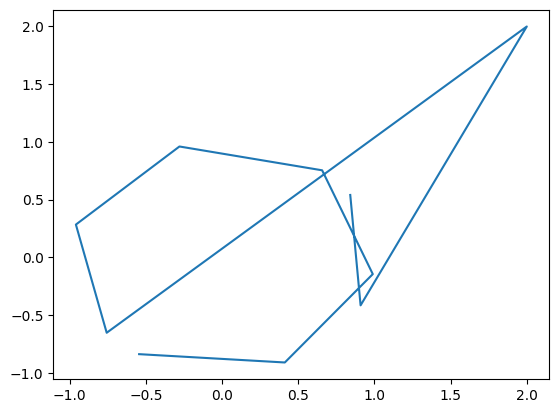

In [148]:
a = 2357285.970587522
b = timedelta(seconds = a)
print(b)

Me = 5.9742e24
Mm = 7.35e22
Mt = Me + Mm
Re = d*Mm/Mt
Rm = d*Me/Mt
G0 = 6.6726e-11
d = 3.844e8

P = np.sqrt(4 * np.pi**2 * (d)**3 / G0 / Mt)
print(timedelta(seconds = P))
P = np.sqrt(4 * np.pi**2 * d**3 / G0 / Me)
print(timedelta(seconds = P))
P = np.sqrt(4 * np.pi**2 * d**3 / G0 / Mm)
print(timedelta(seconds = P))

test = np.zeros((10,2))
t = np.linspace(1,10,10)
test = [[np.sin(t[i]),np.cos(t[i])] for i in range(10)]
test[2] = [2,2]
print(test)
ax = plt.figure().add_subplot()
test = np.transpose(test)
print("\n")
print(np.shape(test))
print(test)
print(test[1])
ax.plot(*test)

Simpson's Rule\
Taylor expansion\
Runge-Kutta

### TBP Calc ###
### $\frac{d^2x}{dt^2} = -G m_E \frac{(x - x_E)}{d_E^3} - G m_M \frac{(x - x_M)}{d_M^3}$ ###
### $\frac{d^2y}{dt^2} = -G m_E \frac{(y - y_E)}{d_E^3} - G m_M \frac{(y - y_M)}{d_M^3}$ ###

   DEBUG LEVEL START
Start time     = 2023-11-01 13:29:08.273902 seconds
S position          = [0. 0.] m
S velocity          = [0. 0.] m s^-1
S acceleration      = [0. 0.] m s^-2
   DEBUG LEVEL START
Start time     = 2023-11-01 13:29:08.273902 seconds
S position          = [4.41257094e+08 0.00000000e+00] m
S velocity          = [   0.         1176.14074955] m s^-1
S acceleration      = [0 0] m s^-2
[4.41257094e+08 0.00000000e+00]
[   0.         1176.14074955]
[3.84069556e+08 1.83905728e+08]
[-693.98410024 1137.82188748]
[2.33024439e+08 3.43057241e+08]
[-1193.36259321   840.0223626 ]
[2.36240275e+07 4.37525078e+08]
[-1417.53725681   350.45805296]
[-1.97478705e+08  4.56285221e+08]
[-1361.92345842   -87.2523193 ]
[-3.98252601e+08  4.18696300e+08]
[-1185.12261058  -365.79745388]
[-5.69431432e+08  3.47799776e+08]
[-995.54694456 -520.49591127]
[-7.12311777e+08  2.58931404e+08]
[-827.16668683 -601.40103284]
[-8.30776499e+08  1.60943354e+08]
[-684.60566265 -640.48415047]
[-9.28676155e+08  5.88

<Figure size 640x480 with 0 Axes>

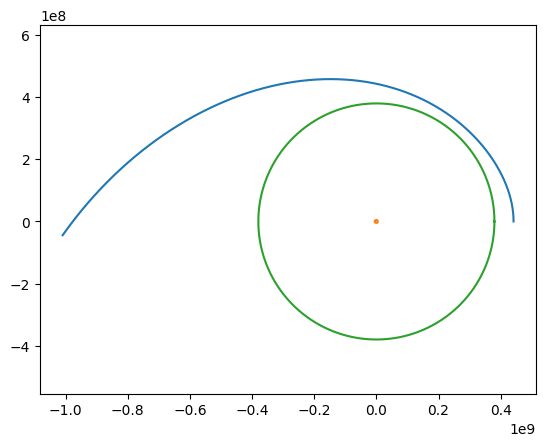

In [177]:
'''
def ODE1(x, y, t):
    xE, yE = Epos(t)[0], Epos(t)[1]
    xM, yM = Epos(t)[0], Epos(t)[1]
    dE = np.sqrt((x - xE)**2 + (y - yE)**2)
    dM = 
    output = -G0*Me* (x - )
'''

def RK4ODEsolve3BP(t_0, t_f, dt): #t_0: time initial [seconds], t_f: time final [seconds], dt: time step
    global Spos, Svel
    steps = int((t_f - t_0) / dt)
    tList = np.linspace(t_0, t_f, steps + 1)
    SposList = np.zeros((steps + 1, 2))
    EposList = np.zeros((steps + 1, 2))
    MposList = np.zeros((steps + 1, 2))
    def d2t_r(time, x, y):
        Epos = calcEpos(time)
        Mpos = calcMpos(time)
        dE = np.sqrt((x - Epos[0])**2 + (y - Epos[1])**2)
        dM = np.sqrt((x - Mpos[0])**2 + (y - Mpos[1])**2)
        x2 = -G0*mE*(x - Epos[0])/dE**3 -G0*mM*(x -Mpos[0])/dM**3
        y2 = -G0*mE*(y - Epos[1])/dE**3 -G0*mM*(y -Mpos[1])/dM**3
        Sacc = np.array([x2,y2])
        return Sacc
    t = t_0
    SposList[0] = Spos
    EposList[0] = calcEpos(t_0)
    MposList[0] = calcMpos(t_0)
    for i in range(steps):
        w0 = d2t_r(t, *Spos)
        u1 = Spos + dt * Svel / 2 #u, v, w denote position, velocity, and acceleration (respectively) of test points
        v1 = Svel + dt * w0 / 2
        w1 = d2t_r(t + dt/2, *u1)
        u2 = Spos + dt * v1 / 2
        v2 = Svel + dt * w1 / 2
        w2 = d2t_r(t + dt/2, *u2)
        u3 = Spos + dt * v2
        v3 = Svel + dt * w2
        w3 = d2t_r(t + dt, *u3)
        if i% (int(steps/10)) == 0:
            print(Spos)
            print(Svel)
        Spos = Spos + dt * (Svel + v1 + v2 + v3) / 6
        Svel = Svel + dt * (w0 + 2*w1 + 2*w2 + w3) / 6
        t = tList[i+1]

        SposList[i+1] = Spos
        EposList[i+1] = calcEpos(t)
        MposList[i+1] = calcMpos(t)
    SposList = np.transpose(SposList)
    EposList = np.transpose(EposList)
    MposList = np.transpose(MposList)
    ax = plt.clf()
    ax = plt.figure().add_subplot()
    ax.axis('equal')
    ax.plot(*SposList,label='S')
    ax.plot(*EposList,label='E')
    ax.plot(*MposList,label='M')
    out = plt.show() #change to plt.show when ready
    return out
initialize('zeros')
initialize('fillVectors',inSpos=[l2,0],inSvel=[0,l2vel])
RK4ODEsolve3BP(0, P, 1)

## Example problem: 1st order ODE ##
$\frac{dN}{dt}=\frac{-N}{\tau}$\
$\ln|N|=\frac{-t}{\tau} + c$\
$N=N_0e^{-\frac{t}{\tau}}$\
Solve using Euler's method and RK4

In [ ]:
def EulerODEsolveN(N_0, tau, t_0, t_f, dt):
    
    steps = int((t_f - t_0) / dt)
    x = np.linspace(t_0, t_f,steps+1)
    y = np.zeros(steps + 1)
    ana = 100 * np.exp(- (x) / tau)
    def d_tN(N):
        derivative = - N / tau
        return derivative
    N = N_0
    t = t_0
    x[0] = t
    y[0] = N
    for i in range(steps):
        N = N + dt * d_tN(N)
        t = t + dt
        x[i+1] = t
        y[i+1] = N
    plt.figure(0)
    plt.plot(x, y)
    plt.plot(x, ana)
    plt.figure(1)
    plt.plot(x,y-ana)
    out = plt.show
    return out
EulerODEsolveN(100, 5, 0, 20, 1e-2)

In [ ]:
def RK4ODEsolveN(N_0, tau, t_0, t_f, dt):
    steps = int((t_f - t_0) / dt)
    x = np.linspace(t_0, t_f,steps+1)
    y = np.zeros(steps + 1)
    ana = 100 * np.exp(- (x) / tau)
    def d_tN(N):
        derivative = - N / tau
        return derivative
    N = N_0
    t = t_0
    x[0] = t
    y[0] = N
    for i in range(steps):
        k1 = d_tN(N)
        k2 = d_tN(N + k1 * dt/2)
        k3 = d_tN(N + k2 * dt/2)
        k4 = d_tN(N + k3 * dt)
        N = N + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt
        x[i+1] = t
        y[i+1] = N
    plt.figure(0)
    plt.plot(x, y)
    plt.plot(x, ana)
    plt.figure(1)
    plt.plot(x,y-ana)
    out = plt.show
    return out
RK4ODEsolveN(100, 5, 0, 20, 1e-2)


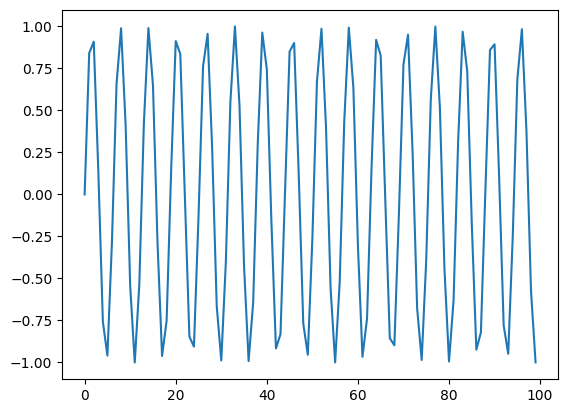

In [57]:
import math
import cmath
x = np.arange(0,100)
y = np.sin(x)
plt.plot(x,y)

